In [1]:
from ema import read

%load_ext autoreload
%autoreload 2

In [2]:
meal_info = read.all_meal_info()

### When did the watch entries occur?

First we'll just visualise these with a histogram...

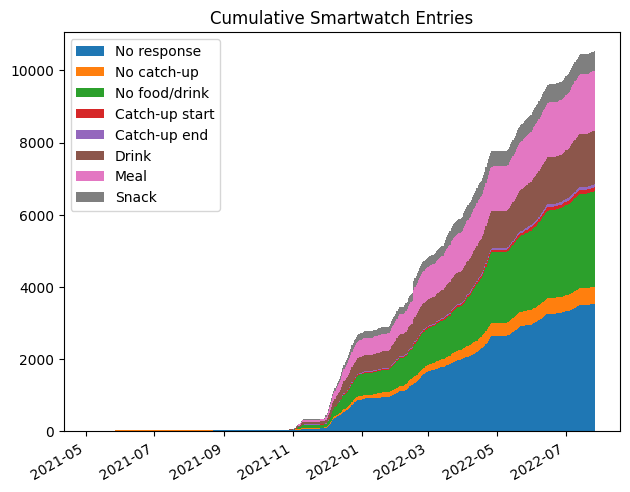

In [3]:
"""
Plot a cumulative histogram showing the number of each type of meal

"""
import pandas as pd
import matplotlib.pyplot as plt


def entry_time_hist(
    meal_timing_df: pd.DataFrame,
    *,
    cumulative: bool = False,
    granularity: str = "1D",
    fig_ax: tuple = None
) -> tuple[plt.Figure, plt.Axes]:
    """
    Plot a histogram of the times of each type of entry in `meal_info`

    :param meal_timing_df: dataframe of smartwatch entries
    :param cumulative: whether to plot a cumulative histogram
    :param granularity: bin granularity; "D", "H", etc. Or bins

    """
    min_time, max_time = meal_info.index.min(), meal_info.index.max()

    fig, axis = plt.subplots() if fig_ax is None else fig_ax
    bins = (
        pd.date_range(min_time, max_time, freq=granularity)
        if isinstance(granularity, str)
        else granularity
    )

    labels = meal_timing_df["meal_type"].unique()
    # Sort the labels
    labels = [
        *[l for l in labels if l.startswith("No ")],
        *[l for l in labels if l.startswith("Catch-up")],
        *labels,
    ]  # Put them in the desired order
    labels = list(dict.fromkeys(labels))  # Remove duplicates, preserve order

    data = [
        meal_timing_df[meal_timing_df["meal_type"] == meal_type].index
        for meal_type in labels
    ]
    axis.hist(data, bins=bins, stacked=True, label=labels, cumulative=cumulative)

    axis.legend()

    fig.autofmt_xdate()
    fig.tight_layout()

    return fig, axis


fig, axis = entry_time_hist(meal_info, cumulative=True)
axis.set_title("Cumulative Smartwatch Entries")
fig.savefig("img/smartwatch_entries_all.png")

There's a long tail - it looks like there's a few entries in early/mid 2021, but then most of them happen from December 2021 until July 2022.

### Data cleaning - no collection date given
For some participants (1/5th of them), no date for the watch's actual collection/pickup was given
(in `SEACO data/Stata Datasets/SEACO-CH20 smartwatch feasibility- for LJ.dta`).

Since we'll want to use these dates later to work out which entries were logged during Ramadan,
we'll remove them from the dataset for now.


18 participants had no collection date given; 21.69% of the total


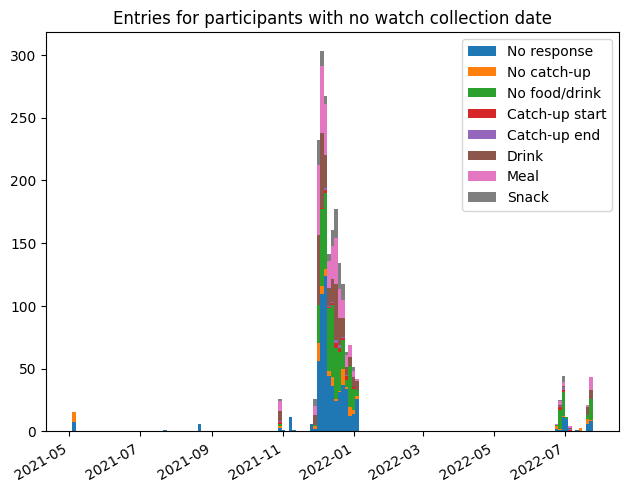

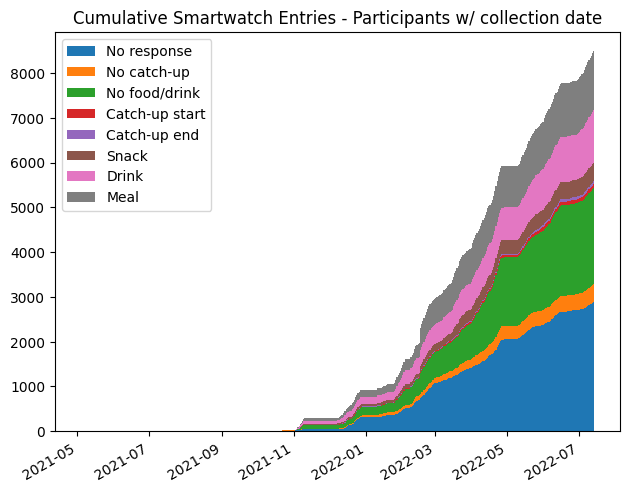

In [4]:
"""
Remove the entries for participants with no collection date given, then re-plot

"""
# Re read the df to avoid issues with re-running the cell
meal_info = read.all_meal_info()

no_collection_date = read.no_collection_date(meal_info["p_id"])
n_total_participants = len(set(meal_info["p_id"]))
print(
    f"{len(no_collection_date)} participants had no collection date given; {len(no_collection_date) / n_total_participants:.2%} of the total"
)

# Plot histogram of entries with no collection date
fig, axis = entry_time_hist(
    meal_info[meal_info["p_id"].isin(no_collection_date)], cumulative=False, granularity="3D"
)
axis.set_title("Entries for participants with no watch collection date")
fig.savefig("img/smartwatch_entries_no_collection_date.png")

# Find how many had no collection date
meal_info = meal_info[~meal_info["p_id"].isin(no_collection_date)]

fig, axis = entry_time_hist(meal_info, cumulative=True)
axis.set_title("Cumulative Smartwatch Entries - Participants w/ collection date")
fig.savefig("img/smartwatch_entries_collection_date_given.png")

There's still the long tail, but this is hopefully fine. (I still want to find out what this means though).

Now let's plot a non-cumulative histogram, indicating Ramadan on the plot...

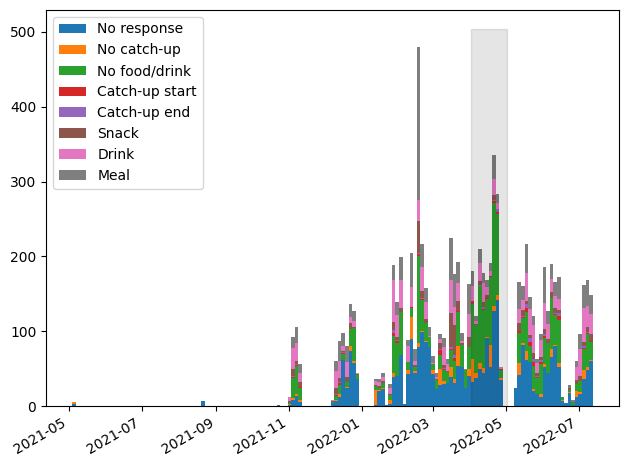

In [5]:
fig, axis = entry_time_hist(meal_info, cumulative=False, granularity="3D")

max_entry = axis.get_ylim()[1]
axis.fill_between(read.ramadan_2022(), [0, 0], [max_entry, max_entry], color="k", alpha=0.1)

There are a few entries before November 2021, but it looks like the main body of the study started after that

Let's look at the fraction of events on each day that were no response vs a meaningful entry (Meal/Drink/Snack). Let's also plot the fraction of meaningful events that were no response vs a Meal/Drink/Snack...

/tmp/ipykernel_51435/4234707158.py:24: RuntimeWarning: invalid value encountered in divide
  errs = np.sqrt(entries * total / (entries + total))
/tmp/ipykernel_51435/4234707158.py:26: RuntimeWarning: invalid value encountered in divide
  no_response, no_food, yes_food = entries / total


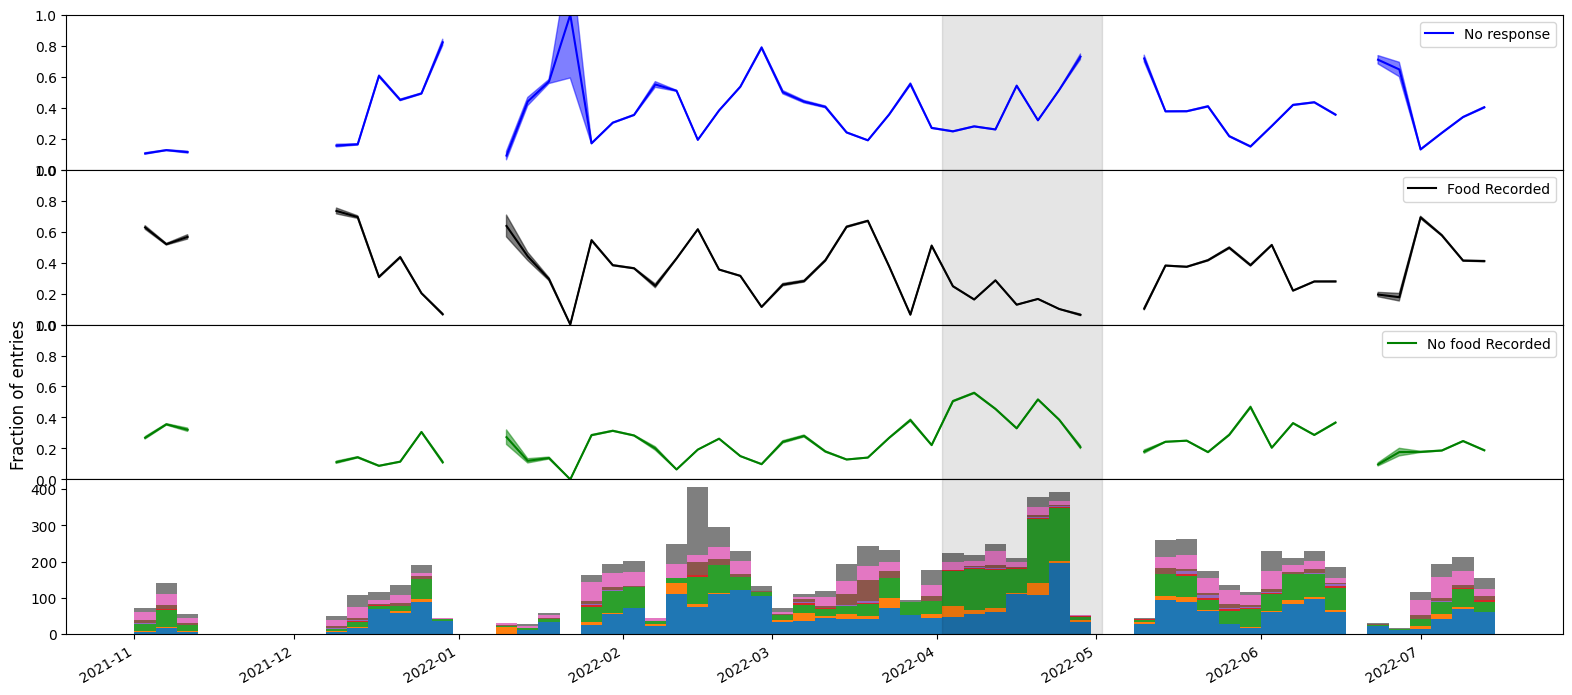

In [12]:
"""
Find the fraction of entries on each date that were No response vs meal vs No food

"""
import numpy as np

# Define bins
n_days = 4
bins = pd.date_range("2021-11-01", "2022-07-15", freq=f"{n_days}D")
centres = bins[1:] - pd.Timedelta(days=n_days / 2)

entries = []
# Find the totals in each bin
for meal_type in [["No response"], ["No food/drink"], ["Snack", "Drink", "Meal"]]:
    df_slice = meal_info[meal_info["meal_type"].isin(meal_type)]

    hist, _ = np.histogram(df_slice.index, bins=bins)
    entries.append(hist)

# Find the fractions and their errors
entries = np.array(entries)
total = np.sum(entries, axis=0)

errs = np.sqrt(entries * total / (entries + total))

no_response, no_food, yes_food = entries / total


def frac_err(a, b):
    return np.sqrt((a * b) / (a + b))


no_response_err = frac_err(no_response, total) / total
yes_food_err = frac_err(yes_food, total) / total
no_food_err = frac_err(no_food, total) / total


# Plot the fractions
def plot_with_err(axis, x, y, y_err, *, label, **kwargs):
    axis.plot(x, y, **kwargs, label=label)
    axis.fill_between(x, y + y_err, y - y_err, alpha=0.5, **kwargs)


fig, axes = plt.subplots(4, 1, sharex=True, figsize=(16, 8), gridspec_kw={"hspace": 0})


plot_with_err(
    axes[0], centres, no_response, no_response_err, color="b", label="No response"
)
plot_with_err(
    axes[1], centres, yes_food, yes_food_err, color="k", label="Food Recorded"
)
plot_with_err(
    axes[2], centres, no_food, no_food_err, color="g", label="No food Recorded"
)

for axis in axes[:3]:
    axis.set_ylim(0, 1)
    axis.legend()

fig.supylabel("Fraction of entries")

entry_time_hist(meal_info, cumulative=False, granularity=bins, fig_ax=(fig, axes[3]))
axes[3].get_legend().remove()

# Indicate Ramadan
for axis in axes:
    ylim = axis.get_ylim()
    axis.fill_between(read.ramadan_2022(), [0, 0], [ylim[1]] * 2, color="k", alpha=0.1)
    axis.set_ylim(ylim)

_ = fig.autofmt_xdate()
None

Perhaps instead we care about what day of the study the participant was on, instead of the day in the year...

In [ ]:
import numpy as np

# Find each unique user
p_ids = meal_info["p_id"].unique()

# Find the first date for each participant
first_dates = []
for p_id in p_ids:
    dates = pd.unique(meal_info[meal_info["p_id"] == p_id]["firstdate"])
    assert len(dates) == 1, f"Multiple first dates for participant {p_id}"

    first_dates.append(pd.to_datetime(dates[0], format=r"%d %b %y"))

first_dates = pd.Series(first_dates)

# build up a matrix of participant ids and non-response rate
non_response_matrix = np.ones((len(p_ids), 8)) * np.nan
response_matrix = np.ones((len(p_ids), 8)) * np.nan

# For each participant, find the non-response rate for each of the eight days following their first recording
for p_id, start_date, non_response_row, response_row in zip(
    p_ids, first_dates, non_response_matrix, response_matrix
):
    # Slice the dataframe to find the meals recorded by this participant
    this_participant = meal_info[meal_info["p_id"] == p_id]

    # Find the non-response rate for each day
    for i in range(8):
        date = start_date + pd.Timedelta(days=i)
        this_date = this_participant[this_participant.index.date == date.date()]

        # Find the number of "no response" entries
        negative_response = ["No response"]
        n_no_response = np.sum(this_date["meal_type"].isin(negative_response))

        non_response_row[i] = n_no_response

        # Find the number of "Drink", "Meal", "Snack", "No food/drink" entries
        positive_response = ["Drink", "Meal", "Snack", "No food/drink"]
        n_response = np.sum(this_date["meal_type"].isin(positive_response))

        response_row[i] = n_response

        # Error if there's anything else
        ignore_response = ["No catch-up", "Catch-up start", "Catch-up end"]
        assert (
            this_date["meal_type"]
            .isin(ignore_response + positive_response + negative_response)
            .values.all()
        ), "Unexpected meal type encountered"

In [ ]:
"""
Scatter plot of response rate vs. non-response rate for each participant on each day of the study

"""
from scipy.stats import linregress

fig, axis = plt.subplots()

axis.scatter(non_response_matrix.ravel(), response_matrix.ravel())
axis.set_xlabel("Number of No Responses")
axis.set_ylabel("Number of responses")

# Linear regression
fit = linregress(
    non_response_matrix.ravel(), response_matrix.ravel(), alternative="two-sided"
)
fit_x = axis.get_xlim()
axis.plot(fit_x, [fit.intercept + fit.slope * x for x in fit_x], color="red")
axis.fill_between(
    fit_x,
    [
        fit.intercept - fit.intercept_stderr + (fit.slope - fit.stderr) * x
        for x in fit_x
    ],
    [
        fit.intercept + fit.intercept_stderr + (fit.slope + fit.stderr) * x
        for x in fit_x
    ],
    color="red",
    alpha=0.3,
    edgecolor=None,
)
axis.set_xlim(fit_x)

axis.set_title(f"{fit.rvalue=:.3f}")

fig.savefig("img/response_scatter.svg")

In [ ]:
"""
Plot histograms of the number of responses and non-responses on each day of the trial

"""
from tqdm import tqdm

fig, axes = plt.subplots(4, 2, figsize=(12, 8))

bins = np.linspace(0, 45, 35)
hist_kw = {"bins": bins, "alpha": 0.3}
for day, axis in tqdm(zip(range(8), axes.ravel()), total=8):
    axis.set_title(f"Day {day + 1}")
    axis.hist(non_response_matrix[:, day], label="No responses", **hist_kw)
    axis.hist(response_matrix[:, day], label="Responses", **hist_kw)

axes[0, 0].legend()

fig.tight_layout()

In [ ]:
"""
On an axis, plot the distributions of responses and non-responses for each day of the trial

"""
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D


def change_colour(violin, colour):
    """
    Change colour of violin plot; there's no easy builtin to do this

    """
    for part in violin:
        if part == "bodies":
            for body in violin["bodies"]:
                body.set_color(colour)
            continue

        violin[part].set_color(colour)


def add_label(axis, violins, labels):
    """
    Add labels to an axis for a series of violin plots

    """
    legend = []
    for violin, label in zip(violins, labels):
        color = violin["bodies"][0].get_facecolor().flatten()
        legend.append(
            (
                (
                    mpatches.Patch(color=color),
                    Line2D([], [], color=color[:3]),  # alpha is ignored
                ),
                label,
            )
        )
    axis.legend(*zip(*legend))


fig, axis = plt.subplots()

viol_kw = {
    "positions": np.arange(8),
    "showmeans": True,
    "showextrema": False,
    "bw_method": 0.05,
}
non_response_viol = axis.violinplot(response_matrix, **viol_kw)
response_viol = axis.violinplot(non_response_matrix, **viol_kw)

change_colour(non_response_viol, "red")
change_colour(response_viol, "blue")

add_label(axis, (non_response_viol, response_viol), ("No responses", "Responded"))

axis.set_xlabel("Day")
axis.set_ylabel("Number of each response type")

axis.set_ylim(-1, 20)
axis.set_yticks(np.arange(0, axis.get_ylim()[1], 2))

In [ ]:
"""
Do something with Ramadan

"""
bins = pd.date_range(*pd.to_datetime(["2021-11", "2022-08"]), freq="1D")
